In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime as dt
import altair as alt
warnings.filterwarnings('ignore')
os.chdir('/Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2')
import app.data as data
import app.charts as charts
import app.views as views
from importlib import reload

reload(data)
reload(charts)

<module 'app.charts' from '/Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/app/charts.py'>

In [123]:
# Load datasets

(df_geo, 
df_order, 
df_order_item, 
df_order_payment, 
df_order_review,
df_product, 
df_seller, 
df_customer, 
df_product_category) = data.load_raw_data()


# Investigate Missing Values

In [124]:
"""
Find nulls
"""
nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values]
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values]
nulls_order_item = df_order_item.loc[:,(df_order_item.isna().sum() > 0)]
nulls_order_payment = df_order_payment.loc[:,(df_order_payment.isna().sum() > 0)]
nulls_order_review = df_order_review.loc[:,(df_order_review.isna().sum() > 0)]
nulls_product = df_product.loc[:,(df_product.isna().sum() > 0)]
nulls_seller = df_seller.loc[:,(df_seller.isna().sum() > 0)]
nulls_product_category = df_product_category.loc[:,(df_product_category.isna().sum() > 0)]
nulls_customer = df_customer.loc[:,(df_customer.isna().sum() > 0)]

print("------Nulls------")
print("Geolocation: ", nulls_geo.shape[1] > 1)
print("Orders: ",nulls_orders.shape[1] > 1)
print("Order Item: ",nulls_order_item.shape[1] > 1)
print("Order Payment: ",nulls_order_payment.shape[1] > 1)
print("Order Review: ",nulls_order_review.shape[1] > 1)
print("Product: ",nulls_product.shape[1] > 1)
print("Seller: ",nulls_seller.shape[1] > 1)
print("Product Category: ",nulls_product_category.shape[1] > 1)
print("Customer: ",nulls_customer.shape[1] > 1)


------Nulls------
Geolocation:  False
Orders:  True
Order Item:  False
Order Payment:  False
Order Review:  True
Product:  True
Seller:  False
Product Category:  False
Customer:  False


- *Orders*, *Order Review*, and *Product* tables have null values

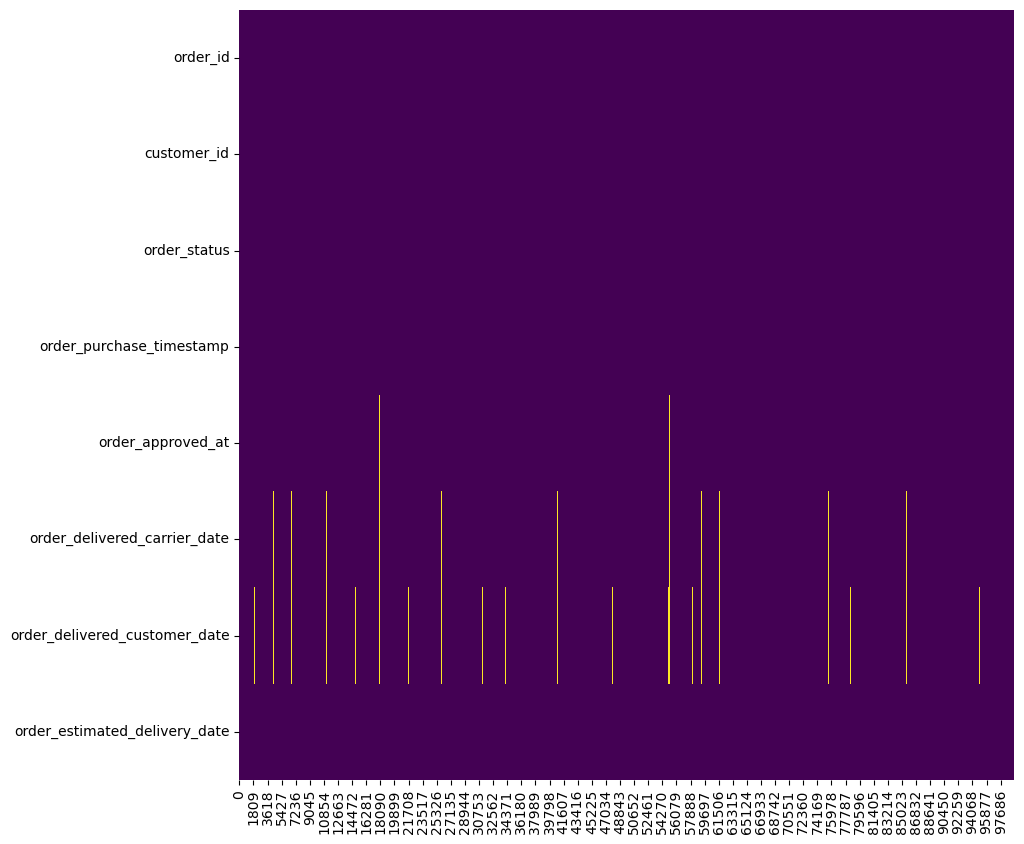

In [125]:
"""
Visualize missing values in Orders table
"""
charts.missingness_heatmap(df_order)

**Observation:** Missing values cluster around 'order_delivered_customer_date' and 'order_delivered_carrier_date', with some in 'order_approved_at'

**Next Steps:** Investigate missing values

## Investigate nulls in 'order_delivered_customer_date' and 'order_delivered_carrier_date'

In [126]:
"""
Features: Order Purchase Date, Delivery Null Count
"""

df_order = data.convert_to_datetime(df_order)

df_order = data.add_date_features(df_order)

customer_all, carrier_all = views.get_delivery_nulls(df_order)

customer_nulls_chart, carrier_nulls_chart = charts.delivery_nulls_chart(customer_all, carrier_all)

customer_nulls_chart | carrier_nulls_chart




alt.HConcatChart(...)

**Observation:** Missing values show a mild, gradual increase through the year, with a slight uptick coinciding with major spikes in total orders in around Jan 2018. 

**Hypothesis:** The increase in missing values is possibly due to the increase in orders, leading to an increase in cancellations, resulting in missing values in delivery dates.

**Next Step:** Check for a rise in cancelled orders during these high-volume periods to validate this hypothesis and inform imputation strategy.

In [127]:
"""
Show cancelled orders by date
"""
chart = charts.cancellation_chart(df_order)
chart


alt.Chart(...)

**Observation:** Cancelled orders spike in Jan 2018. This finding supports the hypothesis that an increase in missing delivery values is due to a increased purchases, resulting in more cancellations. 
**Next Step:** Impute delivery time.

## Impute Delivery Times

In [17]:
"""
Impute Delivery Dates
"""
from scipy.stats import lognorm

# Calculate delivery time without nulls
df_order['delivery_time'] = df_order['order_delivered_customer_date'] - df_order['order_purchase_timestamp']  
df_order['delivery_time'] = df_order['delivery_time'].dt.days

# Calculate mean and std of delivery time
mask = df_order['delivery_time'].isna()

# Impute missing delivery times 
delivery_mean = df_order['delivery_time'].mean()
delivery_std = df_order['delivery_time'].std()
df_order.loc[mask, 'delivery_time'] = abs(lognorm.rvs(s=delivery_std, scale=np.exp(delivery_mean)))

# Impute customer and carrier date with purchase date plus average delivery time
df_order.loc[customer_missing_mask, 'order_delivered_customer_date'] = df_order.loc[customer_missing_mask, 'order_purchase_timestamp']+ dt.timedelta(days=delivery_mean)
df_order.loc[customer_missing_mask, 'order_delivered_carrier_date'] = df_order.loc[customer_missing_mask, 'order_purchase_timestamp']+ dt.timedelta(days=delivery_mean)

TypeError: cannot subtract DatetimeArray from ndarray

## Investigate missing values in 'order_approved_at'

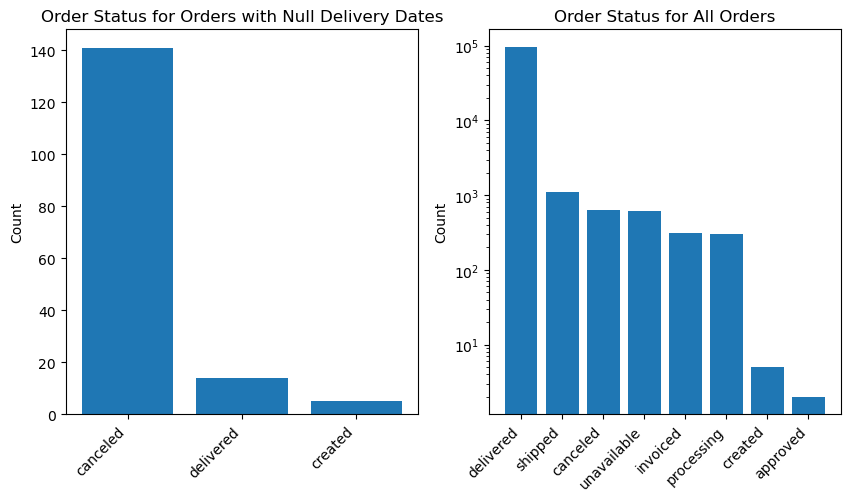

In [ ]:
"""
Determining null values in 'order_approved_at' column
"""

fig, ax = plt.subplots(1,2, figsize=(10,5))

df_order_approved_nulls = df_order.loc[df_order['order_approved_at'].isna()]

# Plot order status for orders with null values in 'order_approved_at'
idx = df_order_approved_nulls.loc[:,"order_status"].value_counts().index
data = df_order_approved_nulls.loc[:,"order_status"].value_counts().values

ax[0].bar(idx, data)
ax[0].set_xticklabels(idx, rotation=45, ha='right')
ax[0].set_ylabel('Count')
ax[0].set_title('Order Status for Orders with Null Delivery Dates')

# Plot order status for all orders
idx = df_order.loc[:,"order_status"].value_counts().index
data = df_order.loc[:,"order_status"].value_counts().values

ax[1].bar(idx, data)
ax[1].set_xticklabels(idx, rotation=45, ha='right')
ax[1].set_ylabel('Count')
ax[1].set_title('Order Status for All Orders')
ax[1].set_yscale('log')

plt.show()



**Observation:** Sales with null delivery dates have disproportionately high cancellations when compared to order status of entire dataset. 

**Hypothesis:** These missing values are likely not missing at random (MNAR), but instead are due to the system's handling of canceled orders, which may skip the approval step.

**Recommendation:** Investigate the order approval and cancellation workflow to confirm if the process intentionally omits "order_approved_at" for canceled orders.


# Feature Engineering

## Discretize Purchasing Power

In [ ]:
"""
customer (PK: customer_id) -> order (PK: order_id) -> order_item (FK: product_id) -> product (FK: product_id)
customer (PK: customer_id) -> payment (FK: order_id)
"""

#! Move to preprocessing script
merged = pd.merge(df_customer, df_order, on='customer_id', how='inner')
merged = pd.merge(merged, df_order_item, on='order_id', how='inner')
merged = pd.merge(merged, df_product, on='product_id', how='inner')
merged = pd.merge(merged, df_order_payment, on='order_id', how='inner')



In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
"""
Discretize Customer Spending
"""

# Group by customer and sum payment value
customer_spending = merged.groupby('customer_id')['payment_value'].sum().to_frame()

# Discretize spending
kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# Fit and transform
kbd.fit(customer_spending)
customer_spending['customer_spending'] = kbd.transform(customer_spending)

# Merge with customer dataset
df_customer = pd.merge(df_customer, customer_spending, on='customer_id', how='inner')


## Add Regions Feature and Encode

In [34]:
"""Add Column for Region in Customer and Geolocation datasets"""

state_to_region = {
    'SP': 'Southeast',
    'MG': 'Southeast',
    'RJ': 'Southeast',
    'ES': 'Southeast',
    'PR': 'South',
    'SC': 'South',
    'RS': 'South',
    'DF': 'Central-West',
    'GO': 'Central-West',
    'MS': 'Central-West',
    'MT': 'Central-West',
    'BA': 'Northeast',
    'SE': 'Northeast',
    'AL': 'Northeast',
    'PE': 'Northeast',
    'PB': 'Northeast',
    'RN': 'Northeast',
    'CE': 'Northeast',
    'PI': 'Northeast',
    'MA': 'Northeast',
    'PA': 'North',
    'AM': 'North',
    'AP': 'North',
    'RO': 'North',
    'AC': 'North',
    'RR': 'North',
    'TO': 'North'
}

df_customer['customer_region'] = df_customer['customer_state'].map(state_to_region)
df_geo['geolocation_region'] = df_geo['geolocation_state'].map(state_to_region)


In [35]:
"""
Merge Product Category Name Translation with Product Dataset
"""
df_product = pd.merge(df_product, df_product_category, on='product_category_name', how='left')
df_product.head()
df_product.drop(columns=['product_category_name'], inplace=True)
df_product.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)


In [36]:
from sklearn.preprocessing import OneHotEncoder
"""
One Hot Encode Region in Customer Dataset
"""

# Encode Region
encoder = OneHotEncoder()
one_hot_region = encoder.fit_transform(df_customer[['customer_region']])
one_hot_region_df = pd.DataFrame(one_hot_region.toarray(), columns=encoder.get_feature_names_out())
df_customer = pd.concat([df_customer, one_hot_region_df], axis=1)

encoder = OneHotEncoder()
one_hot_product_category = encoder.fit_transform(df_product[['product_category_name']])
one_hot_product_category_df = pd.DataFrame(one_hot_product_category.toarray(), columns=encoder.get_feature_names_out())
df_product = pd.concat([df_product, one_hot_product_category_df], axis=1)

encoder = OneHotEncoder()
one_hot_seller_city = encoder.fit_transform(df_seller[['seller_city']])
one_hot_seller_city_df = pd.DataFrame(one_hot_seller_city.toarray(), columns=encoder.get_feature_names_out())
df_seller = pd.concat([df_seller, one_hot_seller_city_df], axis=1)



# Output

In [37]:
# Processed Data
df_order.to_csv('./data/processed/orders.csv', index=False)
df_customer.to_csv('./data/processed/customers.csv', index=False)
df_geo.to_csv('./data/processed/geolocation.csv', index=False)
df_order_item.to_csv('./data/processed/order_items.csv', index=False)
df_order_payment.to_csv('./data/processed/order_payments.csv', index=False)
df_order_review.to_csv('./data/processed/order_reviews.csv', index=False)
df_product.to_csv('./data/processed/products.csv', index=False)
df_seller.to_csv('./data/processed/sellers.csv', index=False)
df_product_category.to_csv('./data/processed/product_category.csv', index=False)


